
# Дослідження моделі дерева рішень. А також порівняння з LogisticRegression і метричною моделлю

## Завдання
Натренувати класифікатор на датасеті

https://archive.ics.uci.edu/ml/datasets/credit+approval

- DecisionTreeClassifier
- Провести всі етапи (підготовка, графічний аналіз, нові фічі....)
- Додатково: порівняти із LogisticRegression і метричною моделлю

---

## Необхідні імпорти


In [34]:

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from matplotlib import pyplot as plt


In [35]:

# Завантаження датасету
file_path = 'credit+approval/crx.data'
data = pd.read_csv(file_path, header=None)

# Додавання назв колонок
column_names = [
    'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
    'A11', 'A12', 'A13', 'A14', 'A15', 'Class'
]
data.columns = column_names

# Перевірка перших рядків
data.head()


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,Class
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+



## Обробка пропущених значень
У даних є пропущені значення, які представлені як `?`. Їх потрібно обробити:
- Для категоріальних змінних — замінити модою (найчастіше зустрічається значення).У таких випадках, якщо значення пропущене, логічно замінити його найпоширенішим значенням, адже це максимізує ймовірність, що це значення є правильним.
- Для числових змінних — замінити медіаною. Якщо у наборі чисел є дуже великі чи дуже маленькі значення (викиди), вони сильно впливають на середнє, але майже не впливають на медіану.


In [36]:
# Обробка пропущених значень

# Заміна всіх значень "?" на NaN (пусті значення) для подальшої обробки пропусків
data.replace('?', np.nan, inplace=True)

# Проходимо по кожній колонці у датафреймі
for col in data.columns:
    # Перевіряємо, чи колонка є категоріальною (тип object)
    if data[col].dtype == "object":
        # Обчислюємо найчастіше зустрічається значення (мода) у колонці
        mode_value = data[col].mode()[0]
        # Замінюємо всі пропущені значення (NaN) на обчислену моду
        data[col] = data[col].fillna(mode_value)
    else:
        # Приводимо числові значення до типу float, замінюючи всі неможливі значення на NaN
        data[col] = pd.to_numeric(data[col], errors="coerce")
        # Обчислюємо медіану (середнє значення у впорядкованому ряду)
        median_value = data[col].median()
        # Замінюємо всі пропущені значення (NaN) у числовій колонці на медіану
        data[col] = data[col].fillna(median_value)


## Візуалізація даних
### Розподіл числових змінних
Розглянемо, як розподілені числові змінні.


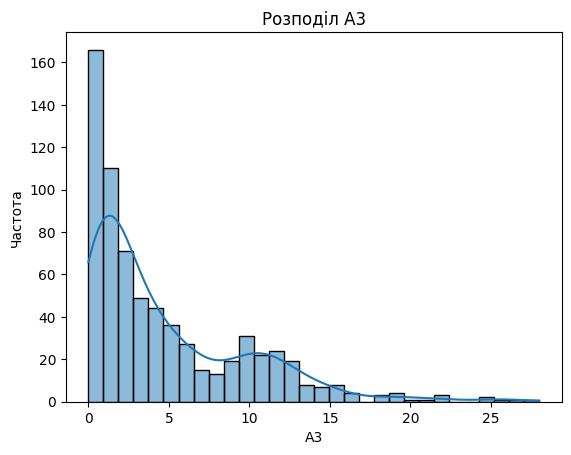

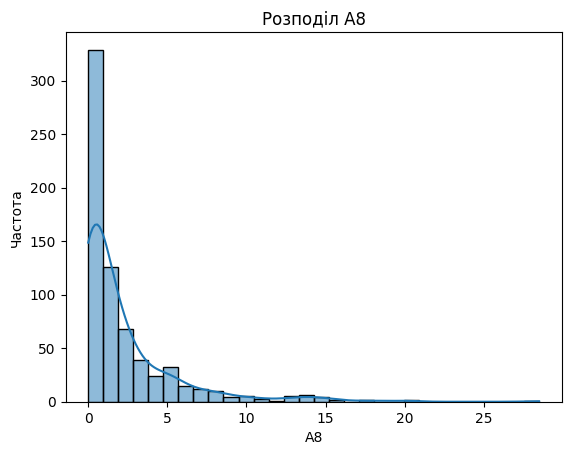

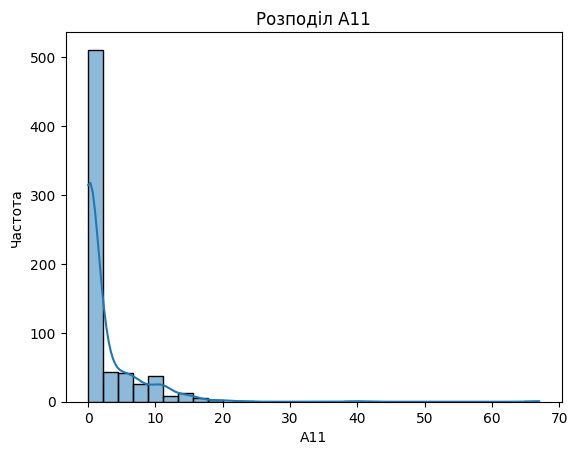

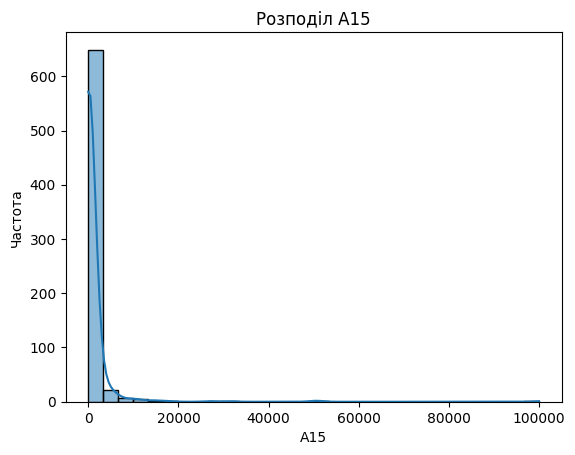

In [37]:

# Візуалізація числових змінних
numerical_columns = ['A3', 'A8', 'A11', 'A15']
for col in numerical_columns:
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Розподіл {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.show()



## Фіч інженірінг
1. Категоріальні змінні будуть закодовані у числові значення.
2. Всі дані будуть підготовлені для тренування моделей.


In [38]:

# Кодування категоріальних змінних
categorical_columns = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13', 'Class']  # Список категоріальних змінних
for col in categorical_columns:
    # Перетворюємо кожну категоріальну колонку у числові коди
    # .astype('category') - задає тип категорії
    # .cat.codes - замінює категорії на унікальні числові значення
    data[col] = data[col].astype('category').cat.codes

# Розділення на фічі та цільову змінну
X = data.drop(columns=['Class'])
y = data['Class']

# Розділення на тренувальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## Тренування моделей
### DecisionTreeClassifier


In [39]:

# Тренування DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# Оцінка моделі
print("DecisionTreeClassifier")
print("Accuracy:", accuracy_score(y_test, dt_predictions))
print(classification_report(y_test, dt_predictions))


DecisionTreeClassifier
Accuracy: 0.7681159420289855
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        70
           1       0.76      0.78      0.77        68

    accuracy                           0.77       138
   macro avg       0.77      0.77      0.77       138
weighted avg       0.77      0.77      0.77       138



### LogisticRegression

In [40]:
# Масштабування ознак
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Тренування LogisticRegression з масштабованими даними
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_predictions = lr_model.predict(X_test_scaled)

# Оцінка моделі
print("LogisticRegression with Scaled Features")
print("Accuracy:", accuracy_score(y_test, lr_predictions))
print(classification_report(y_test, lr_predictions))

LogisticRegression with Scaled Features
Accuracy: 0.8478260869565217
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        70
           1       0.84      0.85      0.85        68

    accuracy                           0.85       138
   macro avg       0.85      0.85      0.85       138
weighted avg       0.85      0.85      0.85       138



### KNeighborsClassifier

In [41]:

# Тренування KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# Оцінка моделі
print("KNeighborsClassifier")
print("Accuracy:", accuracy_score(y_test, knn_predictions))
print(classification_report(y_test, knn_predictions))


KNeighborsClassifier
Accuracy: 0.6231884057971014
              precision    recall  f1-score   support

           0       0.69      0.47      0.56        70
           1       0.59      0.78      0.67        68

    accuracy                           0.62       138
   macro avg       0.64      0.63      0.62       138
weighted avg       0.64      0.62      0.61       138




## Порівняння моделей
На основі точності та звітів можна порівняти продуктивність моделей.


                 Model  Accuracy  Precision (Class 0)  Recall (Class 0)  \
0        Decision Tree  0.768116             0.779412          0.757143   
1  Logistic Regression  0.847826             0.855072          0.842857   
2  K-Nearest Neighbors  0.623188             0.687500          0.471429   

   F1-Score (Class 0)  
0            0.768116  
1            0.848921  
2            0.559322  


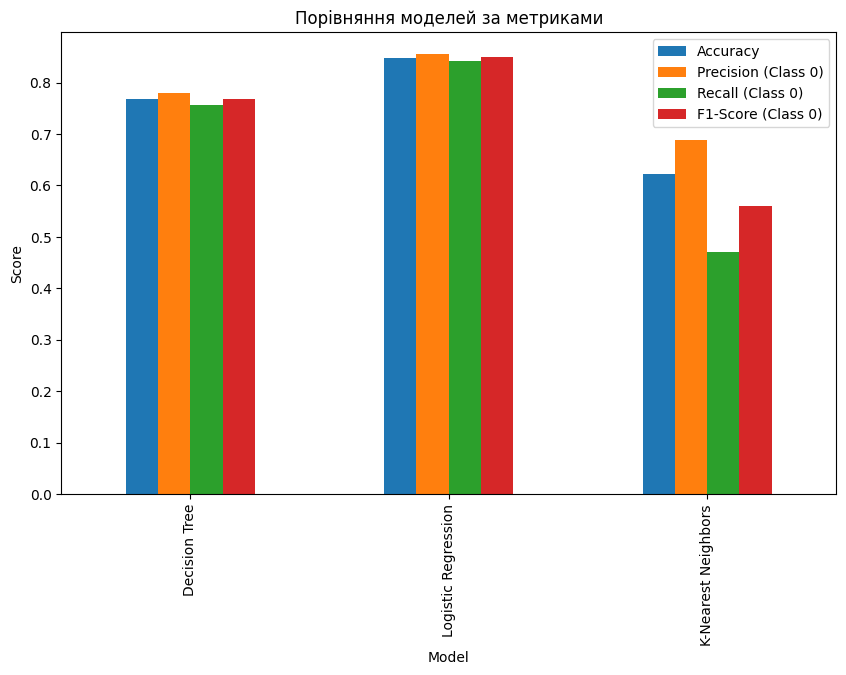

In [42]:
# Порівняння результатів моделей
results = {
    "Model": ["Decision Tree", "Logistic Regression", "K-Nearest Neighbors"],
    "Accuracy": [
        accuracy_score(y_test, dt_predictions),  # Результати Decision Tree
        accuracy_score(y_test, lr_predictions),  # Результати Logistic Regression
        accuracy_score(y_test, knn_predictions)  # Результати KNN
    ],
    "Precision (Class 0)": [
        classification_report(y_test, dt_predictions, output_dict=True)["0"]["precision"],
        classification_report(y_test, lr_predictions, output_dict=True)["0"]["precision"],
        classification_report(y_test, knn_predictions, output_dict=True)["0"]["precision"]
    ],
    "Recall (Class 0)": [
        classification_report(y_test, dt_predictions, output_dict=True)["0"]["recall"],
        classification_report(y_test, lr_predictions, output_dict=True)["0"]["recall"],
        classification_report(y_test, knn_predictions, output_dict=True)["0"]["recall"]
    ],
    "F1-Score (Class 0)": [
        classification_report(y_test, dt_predictions, output_dict=True)["0"]["f1-score"],
        classification_report(y_test, lr_predictions, output_dict=True)["0"]["f1-score"],
        classification_report(y_test, knn_predictions, output_dict=True)["0"]["f1-score"]
    ],
}

# Створюємо таблицю результатів
results_df = pd.DataFrame(results)

# Виведення таблиці
print(results_df)

# Візуалізація результатів
results_df.plot(x="Model", kind="bar", figsize=(10, 6), title="Порівняння моделей за метриками")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(loc="upper right")
plt.show()


## Висновок

Logistic Regression показала найкращі результати за всіма метриками, демонструючи збалансовану продуктивність та стабільність. Decision Tree також показала високі результати, але трохи поступається Logistic Regression. K-Nearest Neighbors має найнижчі показники, особливо для Recall і F1-Score, що потребує оптимізації параметра k і масштабування даних.